# Stuff that makes the notebook work

In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:2.0em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Motivation

- I'd like to enable this kind of robot design loop:

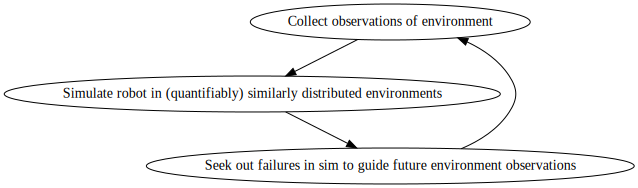

In [2]:
from graphviz import Digraph
dot = Digraph()
dot.node('A', 'Collect observations of environment')
dot.node('B', 'Simulate robot in (quantifiably) similarly distributed environments')
dot.node('C', 'Seek out failures in sim to guide future environment observations')
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'A')
dot 

Focus on one particular unsolved part of this problem: how do we generate **samples** from a distribution of environments?

Parameterize environment as a collection of object identities and poses. "Feasible" environment configurations lie on a **manifold** of **nonpenetrating, statically stable poses.**

In [3]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/x71v_9xcjzs" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

Forward simulation is great for generating, but really hard to "tune" to generate samples distributed like a set of observations.

Generative networks are good at that! Can we use them?

- **:)** Specifically designed to generate samples from a distribution
- **:(** Don't play well with manifold constraints

Need a modified GAN setup instead: project generator outputs are projected to feasibility before discrimination.

# Feasibility Projection for Battleship

**Input**: A list of *N* battleship poses (x, y, $\theta$) and ship lengths ($l \in \mathbb{Z}_{> 0}$), plus game board width and height.

**Output**: A list of *N* battleship poses that is as close as possible to the input, satisfying:
- $x, y \in \mathbb{Z}$
- $\theta \in \{0, \dfrac{\pi}{2}, \pi, \dfrac{3\pi}{2}\}$
- No part of any ship extends outside of the game board.
- Each cell on the board is occupied by at most one ship.

![projectionexample](groupmeetingfigs/battleship_board_projection.png)

## NLP version

Without the integer constraints on $x, y, \theta$, this can be tackled as an NLP:

Info 1


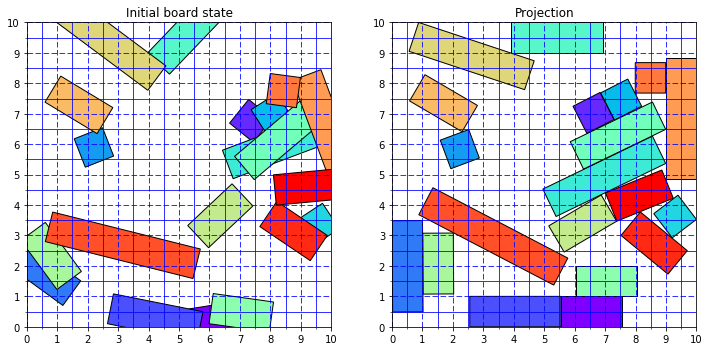

In [8]:
import battleship_board_rbt as bsrbt
import random
import matplotlib.pyplot as plt
random.seed(42)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

board_width = 10
board_height = 10
rbt, q0 = bsrbt.spawn_rbt(board_width, board_height, max_length=5, N=20)
bsrbt.draw_board_state(axs[0], rbt, q0, board_width, board_height)
axs[0].set_title("Initial board state")

q_sol, info, dqf_dq0 = \
    bsrbt.projectToFeasibilityWithIK(rbt, q0, board_width, board_height)
bsrbt.draw_board_state(axs[1], rbt, q_sol, board_width, board_height)
print("Info %d" % info)
axs[1].set_title("Projection");

I like this! But this suffers from all the problems of nonlinear optimization:
- It fails frequently
- It does not provide consistent solutions
- Adding really hard manifold constraints (e.g. the integer contraints, or static stability constraints) will make these problems worse.

(How much worse, in practice? Not sure yet.)

## MIP Version

Recalling Pang's formulation of forward simulation as a mixed integer program (MIP), what if we tackled this with a similar strategy?

For full rigid body dynamics, I'd follow his formulation, but this specific game has an alternative formulation as an MIP that is kind of cute.

Very briefly:
- For the $n^{th}$ ship, allocate one binary variable $b^n_{i, j, k}$ to represent the ship being at the $\{i, j, k\}^{th}$ bin, imposing $ \sum_{i, j, k} b^n_{i, j, k} = 1 $.
- For each location on the grid, create a continuous variable $o_{i, j}$, and impose $o_{i, j} \leq 1$.
- Each location on the grid $o_{i, j}$ is a logical combination of variables $b$. (e.g., for 1-length ships, $o_{i, j} = \sum_{\text{ship } n} \sum_{\text{angle }k} b^n_{i, j, k}$
- Depending on the length of the ship, forbid combinations of $b^n$ that represent part of the ship leaving the boundaries.

All of these relationships are linear (although creating logical relationships requires adding additional intermediate binary variables). Since the continuous optimized pose of each ship is a linear function of $b^n$, we can penalize the L2 norm between the optimized pose and the initial pose of each ship.

Does it work?

In [1]:
%load_ext autoreload
%autoreload 2

import battleship_board as bs

random.seed(43)
board = bs.Board(10, 10)
board.spawn_N_ships(20, max_length=5)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 12)
board.draw(ax1)
fig.show()

board.ships = board.project_to_feasibility_mip(board.ships)
board.draw(ax2)
plt.show()

ImportError: No module named battleship_utils_py

## Conclusions?

- Pretty inefficient transcription of this problem, but functional
- Unfortunately way too slow for using in the inner loop of training
- <sub><sub>but MIP is so cool</sub></sub>